In [1]:
import numpy as np 
import sys, os
sys.path.append('../Netket/')
import netket as nk
from jax import numpy as jnp
import itertools
from scipy.special import comb
from jax import jit, vmap
import jax
import matplotlib.pyplot as plt 
from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial

/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import functools, importlib
# _orig_lru_cache = functools.lru_cache
# functools.lru_cache = lambda *args, **kwargs: (lambda f: f)   # no-op decorator

# import cluster_expansion
# importlib.reload(cluster_expansion)   # ensures module is loaded with the no-op

# # restore original decorator so other code behaves normally
# functools.lru_cache = _orig_lru_cache

In [3]:
# n_sites_test = 4
# hilb_test = nk.hilbert.Spin(0.5, n_sites_test)


# psi_test = np.random.rand(2**n_sites_test) + 1j * np.random.rand(2**n_sites_test)


# cluster_coeffs_test = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilb_test)

# # warm-up / measure compile time for a specific num_kept
# k_test = 2**n_sites_test  # you can vary this
# # print(f"Preparing cached meta for n_sites={n_sites_test}...", flush=True)
# prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

# psi_rec = compress_and_reconstruct_cached(cluster_coeffs_test, k_test, hilb_test)


# mask = _get_topk_indices_jit(cluster_coeffs_test, 2) ## correctly returns the mask
# coeffs_sel = cluster_coeffs_test[mask] ## correctly retruns bigges coeffs



# np.abs(cluster_coeffs_test), np.abs(coeffs_sel), mask, np.isclose(psi_test, psi_rec).all()

In [4]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'

h5_files_opt = [os.path.join(f"{data_root}/data/data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_optimal_basis_rbm') if f.endswith('.h5')]
df_opt = analysis.load_outputs_to_dataframe(h5_files_opt, load_eigenstates=False)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

h5_files_raw = [os.path.join(f"{data_root}/data/data_unrotated_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_unrotated_basis_rbm') if f.endswith('.h5')]
df_raw = analysis.load_outputs_to_dataframe(h5_files_raw, load_eigenstates=False)
df_raw = analysis.attach_hypotheses_fields(df_raw, hypotheses)
df_raw["idx"] = df_raw["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_raw))


230
230


In [5]:
df_raw.head()

,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,alpha,...,out,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,idx
0,"[(-0.00078156666-0.000116100564j), (0.00057880...",[(-0.00027742779470296973+0.001121040770471759...,0.006582,-59.506475,-59.114821,0.813042,"[-59.50647460282354, -59.38739299365681, -59.2...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.888354,0.000176,0.991026,8.643026,3.426688e-09,0.002726,197
1,"[(-0.026862022+0.01373564j), (0.013984644+0.01...","[(0.012853937661910385+0.021484904255527924j),...",0.039649,-59.207952,-56.860413,0.527246,"[-59.20795210665185, -59.00170014824606, -57.4...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.775989,0.000188,0.936782,8.577387,5.993588e-04,0.002891,579
2,"[(-0.000111363755+5.868613e-05j), (1.0714799e-...","[(0.07619476421306261-0.29308878994287973j), (...",0.253833,-66.954601,-49.959339,0.999956,"[-66.95460053839189, -59.98157520591883, -58.7...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.823042,0.012544,0.997900,4.378534,5.315327e-10,0.001221,926
3,"[(-0.00035665775-1.2985646e-05j), (-3.690295e-...",[(1.2476695574012563e-05-2.948852174646008e-05...,0.059313,-62.965244,-59.230606,0.923163,"[-62.965243940314274, -62.96264842785983, -60....",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.805314,0.000199,0.965808,8.521219,1.011469e-06,0.002696,758
4,"[(-2.2831866e-05+2.2014683e-05j), (1.5316422e-...",[(-0.00014984551003466323-0.000262814611443579...,0.038403,-50.905041,-48.950138,0.647634,"[-50.90504143696911, -50.625487386857365, -49....",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.823719,0.001213,0.886667,6.714832,5.558926e-08,0.001829,786


In [36]:
n_sites_test = 16
hilb_test = nk.hilbert.Spin(0.5, n_sites_test)
compr_idx_list = sorted(np.array(list(set(np.logspace(1, 16, 100, base=2, dtype=int)))))  


idx = 32
psi_test_exact = df_opt.iloc[idx]['psi_0']
psi_test_RBM = df_opt.iloc[idx]['psi']
cluster_coeffs_test_exact = fwht_coeffs_in_cluster_col_order(np.log(psi_test_exact), hilb_test)
cluster_coeffs_test_RBM = fwht_coeffs_in_cluster_col_order(np.log(psi_test_RBM), hilb_test)

prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

infidels_exact_opt = [infidelity(compress_and_reconstruct_cached(cluster_coeffs_test_exact, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]
infidels_RBM_opt = [infidelity(compress_and_reconstruct_cached(cluster_coeffs_test_RBM, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]

# mask = _get_topk_indices_jit(cluster_coeffs_test, 5)
# mask, jnp.abs(cluster_coeffs_test[mask])


65536


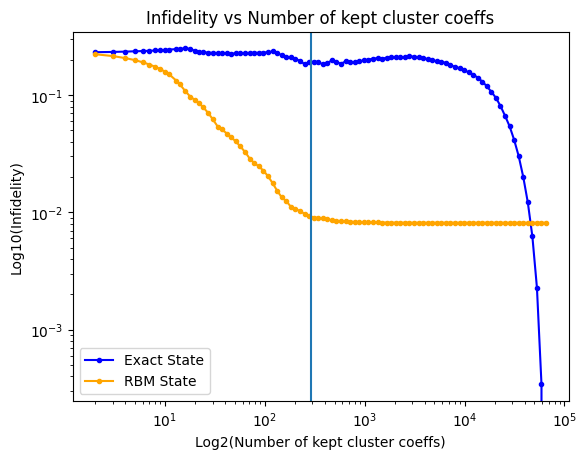

In [37]:
print(max(compr_idx_list))
fig, ax = plt.subplots(1)
ax.plot(compr_idx_list, (infidels_exact_opt), '.-', label='Exact State', color='blue')
ax.plot((compr_idx_list), (infidels_RBM_opt), '.-', label='RBM State', color='orange')
ax.set_xlabel('Log2(Number of kept cluster coeffs)')
ax.set_ylabel('Log10(Infidelity)')
ax.set_title('Infidelity vs Number of kept cluster coeffs')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(288)
plt.show()

In [10]:
np.log2(16 ** 2 + 16 * 2)

np.float64(8.169925001442312)

## Show what the state looks like

In [22]:
psi_test = df_opt.iloc[0]['psi']
psi_exa = df_opt.iloc[0]['psi_0']
hilbert = nk.hilbert.Spin(s=0.5, N=16)

# plt.plot(np.abs(psi_test), label='abs')

# order = np.argsort(np.abs(psi_test))[::-1]
# state_req = hilbert.numbers_to_states([order[2]])
# statemat = np.reshape(state_req, (4,4))
# plt.matshow(statemat, 'ro', label='max amp state')


cluster_coeffs_test = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilbert)
psi_rec = compress_and_reconstruct_cached(cluster_coeffs_test, 10000, hilbert)
infidelity(psi_rec, psi_exa)

np.float64(0.48756156109631654)

In [ ]:
# import functools, importlib
# _orig_lru_cache = functools.lru_cache
# functools.lru_cache = lambda *args, **kwargs: (lambda f: f)   # no-op decorator

# import cluster_expansion
# importlib.reload(cluster_expansion)   # ensures module is loaded with the no-op

# # restore original decorator so other code behaves normally
# functools.lru_cache = _orig_lru_cache